(content:ps_fitting_sbi)=
# Fitting Red Giant Oscillations Part 2: *Flows & Simulation-Based Inference*

***Authors: Marc Hon***

In the first part of this notebook, we have used Markov Chain Monte Carlo sampling to determine Bayesian-based estimates of parameters fitted to the power spectra of red giants. Here, let's go through an alternative way to determine posterior distributions. Instead of sampling, we may approximate it directly using **Simulation-Based Inference (SBI)**.

In [2]:
import warnings, math
import numpy as np
import pandas as pd
import astropy.units as u
import arviz as az
import matplotlib.pyplot as plt
import time as timer
import torch, corner
import scienceplots

from sbi.analysis import pairplot
from sbi.inference import SNPE
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

from pathlib import Path
from astropy.table import Table
from astropy.units import UnitsWarning

warnings.filterwarnings('ignore', category=UnitsWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter1' / 'data'

plt.style.use('science')
fs = 18

2025-02-26 11:09:58.419898: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-26 11:09:59.322864: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-02-26 11:09:59.322942: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2025-02-26 11:09:59.322951: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

To recap:

We are fitting the power density ($P$) of time-resolved photometric observations of red giants as a function of frequency ($\nu$):

$$
\begin{aligned}
P(\nu) = P_n + \sum\limits_{i} \frac{A_i}{1 + (\nu/b_i)^c} + P_g \exp \frac{(\nu-\nu_{\mathrm{max}})^2}{2\sigma^2}
\end{aligned}
$$

We will fit a two-component model ($i=2$), shown in the following code:

In [160]:
def _sLor(nu, A, b, c):
    return A / (1 + (nu / b) ** c)

def _sinc(x):
    return np.sinc(x/np.pi)

def bgModel(theta):
    """
    Background model value at a given frequency 'nu'
    """
    Pn = 100; nuNyq = 283
    A2, b2, A3, b3, Pg, numax, sigmaEnv = theta
    sc = _sinc(np.pi * nu / (2 * nuNyq)) ** 2
    bg = Pn
    bg = bg + sc * _sLor(nu, A2, b2, 4)
    bg = bg + sc * _sLor(nu, A3, b3, 4)
    bg = bg + sc * Pg * np.exp(-((nu - numax) ** 2) / (2 * sigmaEnv ** 2))
    return bg

There are seven free parameters to consider, shown below:

- $A_2$, $A_3$: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Granulation amplitudes.
- $b_2$, $b_3$: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Granulation timescales.
- $P_g$: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Height of the power excess envelope.
- $\nu_{\mathrm{max}}$: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Center of the power excess envelope, known also as the **frequency at maximum power**.
- $\sigma$: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Width of the power excess envelope.

Note that we assume a noise floor of $100$ ppm.

These have been systematically fit across a large ensemble of red giants observed by the *Kepler* mission. We will load the dataset, which comprises $\sim14,600$ entries.

In [161]:
bg_df = pd.read_csv(data_folder_path /'KeplerRG_BG.csv')
bg_df

,A2,A3,b2,b3,Pg,numax,sigmaEnv,Teff,[Fe/H],Phase
0,22737.001773,3622.262794,9.194869,32.499644,7160.525910,29.682241,5.178923,4751.0,-0.08,1.0
1,19301.468236,4907.254684,11.809899,32.123772,9163.734556,29.410508,5.278565,5188.0,-0.21,2.0
2,12330.271869,1858.741735,12.003733,42.358073,3341.057493,40.254536,6.307454,4728.0,-0.15,1.0
3,4938.018676,1027.383223,15.391087,47.867438,1462.296669,45.871939,8.208854,5072.0,-0.12,2.0
4,23879.048501,5280.272149,10.090316,32.097376,8043.019833,35.364523,4.867138,4718.0,-0.02,2.0
...,...,...,...,...,...,...,...,...,...,...
14598,10967.250418,2735.849005,12.053097,37.808500,4983.498344,38.101759,5.308268,4906.0,-0.09,2.0
14599,28033.812005,8813.403509,8.740449,27.931656,10829.477403,28.477241,4.559205,5077.0,-0.53,2.0
14600,2681.631546,673.155384,25.213777,86.723090,909.403904,92.775745,9.802084,4846.0,0.07,1.0
14601,10273.560481,2293.886607,13.323097,47.348840,3240.073356,52.280628,6.986744,4855.0,0.12,1.0


Let's plot a subset of these to visualize the fits over the dataset.

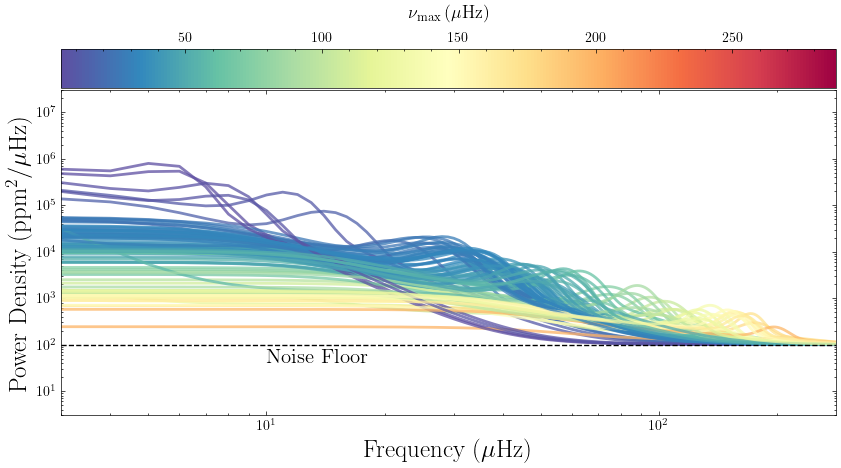

In [166]:
from matplotlib import cm
from matplotlib.colors import Normalize

norm = Normalize(vmin=bg_df.numax.min(), vmax=bg_df.numax.max())  
cmap = plt.cm.Spectral_r

nu = np.linspace(1, 283, 283)
fig = plt.figure(figsize=(10, 5))
for i in range(90):
    plt.loglog(nu, bgModel(bg_df[['A2', 'b2', 'A3', 'b3', 'Pg', 'numax', 'sigmaEnv']].values[i]), alpha=0.75,
               color=cmap(norm(bg_df.numax.values[i])), lw=2)
plt.ylim(3,3e7); plt.xlim(3, 283);
plt.xlabel('Frequency ($\\mu$Hz)', fontsize=fs); plt.ylabel('Power Density (ppm$^2/\\mu$Hz)', fontsize=fs)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
cbar = fig.colorbar(sm, ax=plt.gca(), orientation='horizontal', pad=0.005,location='top')
cbar.set_label(r'$\nu_{\mathrm{max}}\,(\mu$Hz)', fontsize=fs-5, labelpad=10)
cbar.ax.xaxis.set_ticks_position('top')  # Move ticks to the top
cbar.ax.xaxis.set_label_position('top')
plt.axhline(y=100, c='k', ls='--')
plt.text(x=10, y=40, s='Noise Floor', fontsize=fs-3)
plt.xlabel;plt.show()

## Simulations using a realistic range of inputs 

SBI requires us to generate simulations by drawing parameters $\mathbf{\theta}$ from a prior distribution. Convenient distributions to use as priors are uniform (uninformative) priors, but these rarely reflect the range of real datasets. In other words, not all possible combinations of $\theta = [A_2, b_2, A_3, b_3, P_g, \nu_{\mathrm{max}}, \sigma]$ are physical! Let's examine its distribution across our dataset:

> **Note**  
The parameters in $\mathbf{\theta}$ range across several orders of magnitude, so it is much better to display them in logarithmic units.

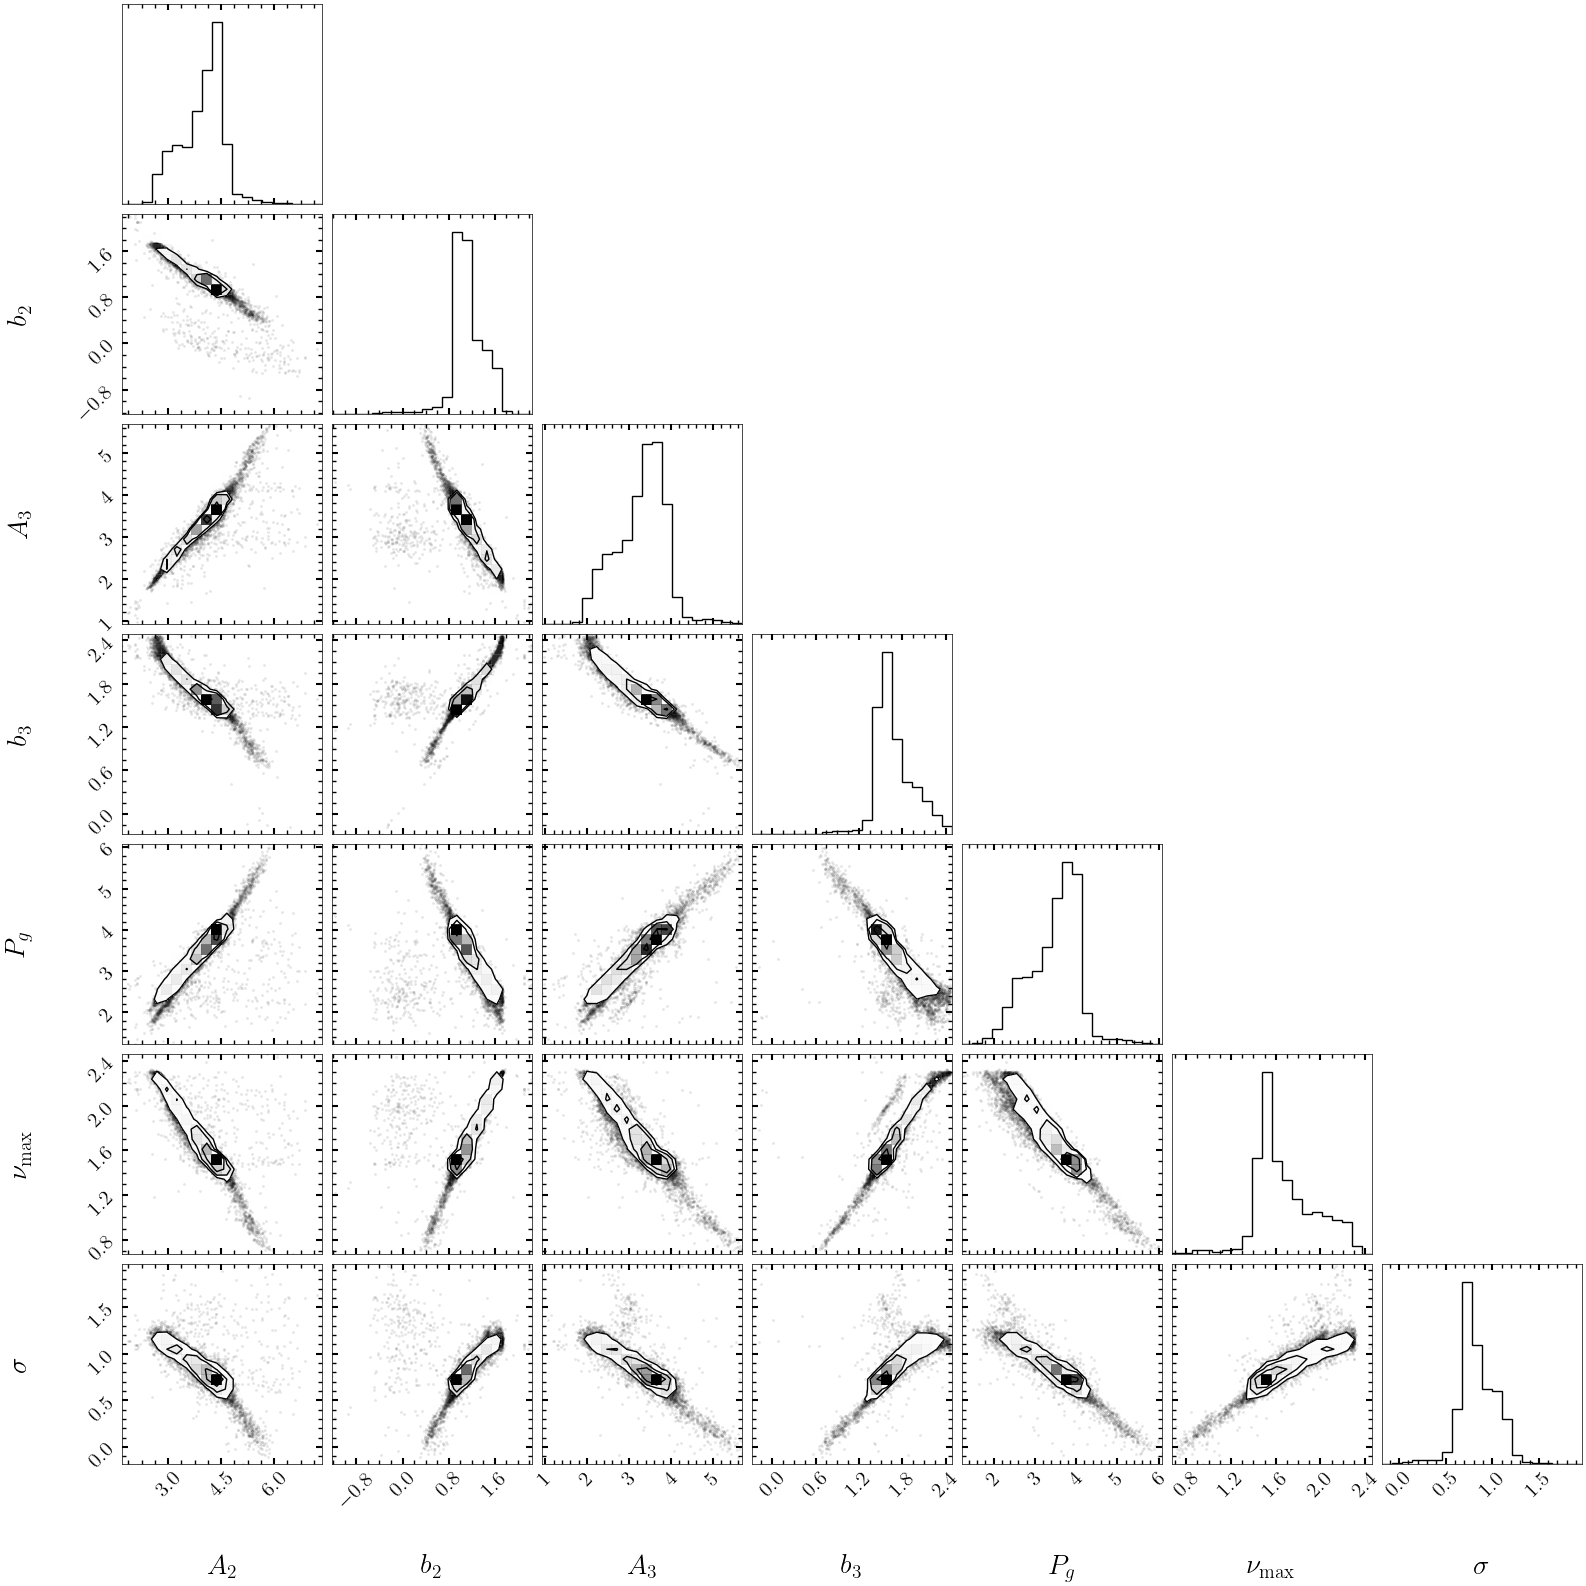

In [57]:
import corner
from copy import deepcopy

labels =['$A_2$', '$b_2$', '$A_3$', '$b_3$', '$P_g$', '$\\nu_\\mathrm{max}$', '$\\sigma$']
theta = np.log10(bg_df[['A2', 'b2', 'A3', 'b3', 'Pg', 'numax', 'sigmaEnv']].values)

fig = corner.corner(theta, labels = labels, figsize=(12, 12)) # plotting the samples in a Corner plot!
for ax in fig.axes:
    ax.xaxis.label.set_size(fs+2)
    ax.yaxis.label.set_size(fs+2)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=fs-3, direction = 'in',top=True, right=True,
                  width=1.5, length = 4,)
    ax.tick_params(axis='both', which='minor', labelsize=fs-6, direction = 'in',top=True, right=True,
              width=1, length = 3)

    ax.xaxis.set_label_coords(0.5, -0.45)
    ax.yaxis.set_label_coords(-0.45, 0.5)
    
axes = np.array(fig.axes).reshape((len(labels), len(labels)))
plt.show()


Training a network to perform SBI requires input training data in the form of $(\theta, x)$ pairs, where $x$ is the simulated data. Hence, we will pass the vector $\theta$ through our simulator function. 

In [59]:
x = np.array([bgModel(tet) for tet in 10**theta]) # beware that theta is already in log units!
theta.shape, x.shape

((14603, 7), (14603, 283))

Our training set is hence a pair of vectors of dimensionality $(N, 7)$ and $(N, 283)$.

### A sample-able training set

What if we wished to randomly sample a representative population of the training data, or sample from a specific higher-density interval of the training distribution? The latter scenario can arise if we wanted to not include outliers in our training sample, for instance.

One way of going about with this is to train a Kernel Density Estimator on the 7D distribution above. We will, however, use a more flexible and powerful tool, a **Normalizing Flow**, as implemented by the `zuko` library, available [here](https://zuko.readthedocs.io/stable/). We will use a simple Neural Spline Flow with comprising 3 stacked MLPs of width 64.

In [64]:
import zuko
import torch.utils.data as utils
from torch.optim.lr_scheduler import ReduceLROnPlateau

device ='cuda'
train_dataset = utils.TensorDataset(torch.Tensor(theta).to(device))
train_dataloader = utils.DataLoader(train_dataset, shuffle=True, batch_size=512) ## Defining dataset

flow = zuko.flows.NSF(features=theta.shape[1], transforms=3, hidden_features=[64] * 3).to(device) ## Defining flow
optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True, min_lr = 1E-12)
iterations = 500 ## training parameters

In [65]:
for i in range(iterations):
    loss_vec = []

    for (X_inp,) in train_dataloader:
        loss = -flow().log_prob(X_inp)  
        loss = loss.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_vec.append(loss.detach().item())
    scheduler.step(np.mean(loss_vec))
    
    if not (i % 100) :
        print('Iterations: %d/%d, Loss: %.4f' %(i, iterations, np.mean(loss_vec)))

Iterations: 0/500, Loss: 18.8831
Iterations: 100/500, Loss: -8.8779
Epoch 00170: reducing learning rate of group 0 to 5.0000e-04.
Iterations: 200/500, Loss: -9.1227
Epoch 00206: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00240: reducing learning rate of group 0 to 1.2500e-04.
Iterations: 300/500, Loss: -9.2040
Epoch 00308: reducing learning rate of group 0 to 6.2500e-05.
Epoch 00334: reducing learning rate of group 0 to 3.1250e-05.
Epoch 00351: reducing learning rate of group 0 to 1.5625e-05.
Epoch 00371: reducing learning rate of group 0 to 7.8125e-06.
Epoch 00397: reducing learning rate of group 0 to 3.9063e-06.
Iterations: 400/500, Loss: -9.2616
Epoch 00413: reducing learning rate of group 0 to 1.9531e-06.
Epoch 00433: reducing learning rate of group 0 to 9.7656e-07.
Epoch 00449: reducing learning rate of group 0 to 4.8828e-07.
Epoch 00467: reducing learning rate of group 0 to 2.4414e-07.


Now, let's sample from our trained flow to get our modelled distribution of $\theta$ and compare it with the true values. We will iterate over the training dataset with the flow, storing the following in each batch:
- Random samples drawn from the flow that approximate the distribution over $\theta$
- Their corresponding log probabilities as estimated by the flow

In [66]:
y_samps, y_logprobs, y_s = [], [], []

for Y_inp in train_dataloader:
    samps,logprobs = flow().rsample_and_log_prob((len(Y_inp[0]),))
    y_logprobs.append(logprobs.data.cpu().numpy())
    y_s.append(Y_inp[0].data.cpu().numpy())
    y_samps.append(samps.data.cpu().numpy())
    
y_logprobs, y_s, y_samps = np.concatenate(y_logprobs), np.concatenate(y_s), np.concatenate(y_samps)

Let's now observe the approximation of $\theta$ using the flow.

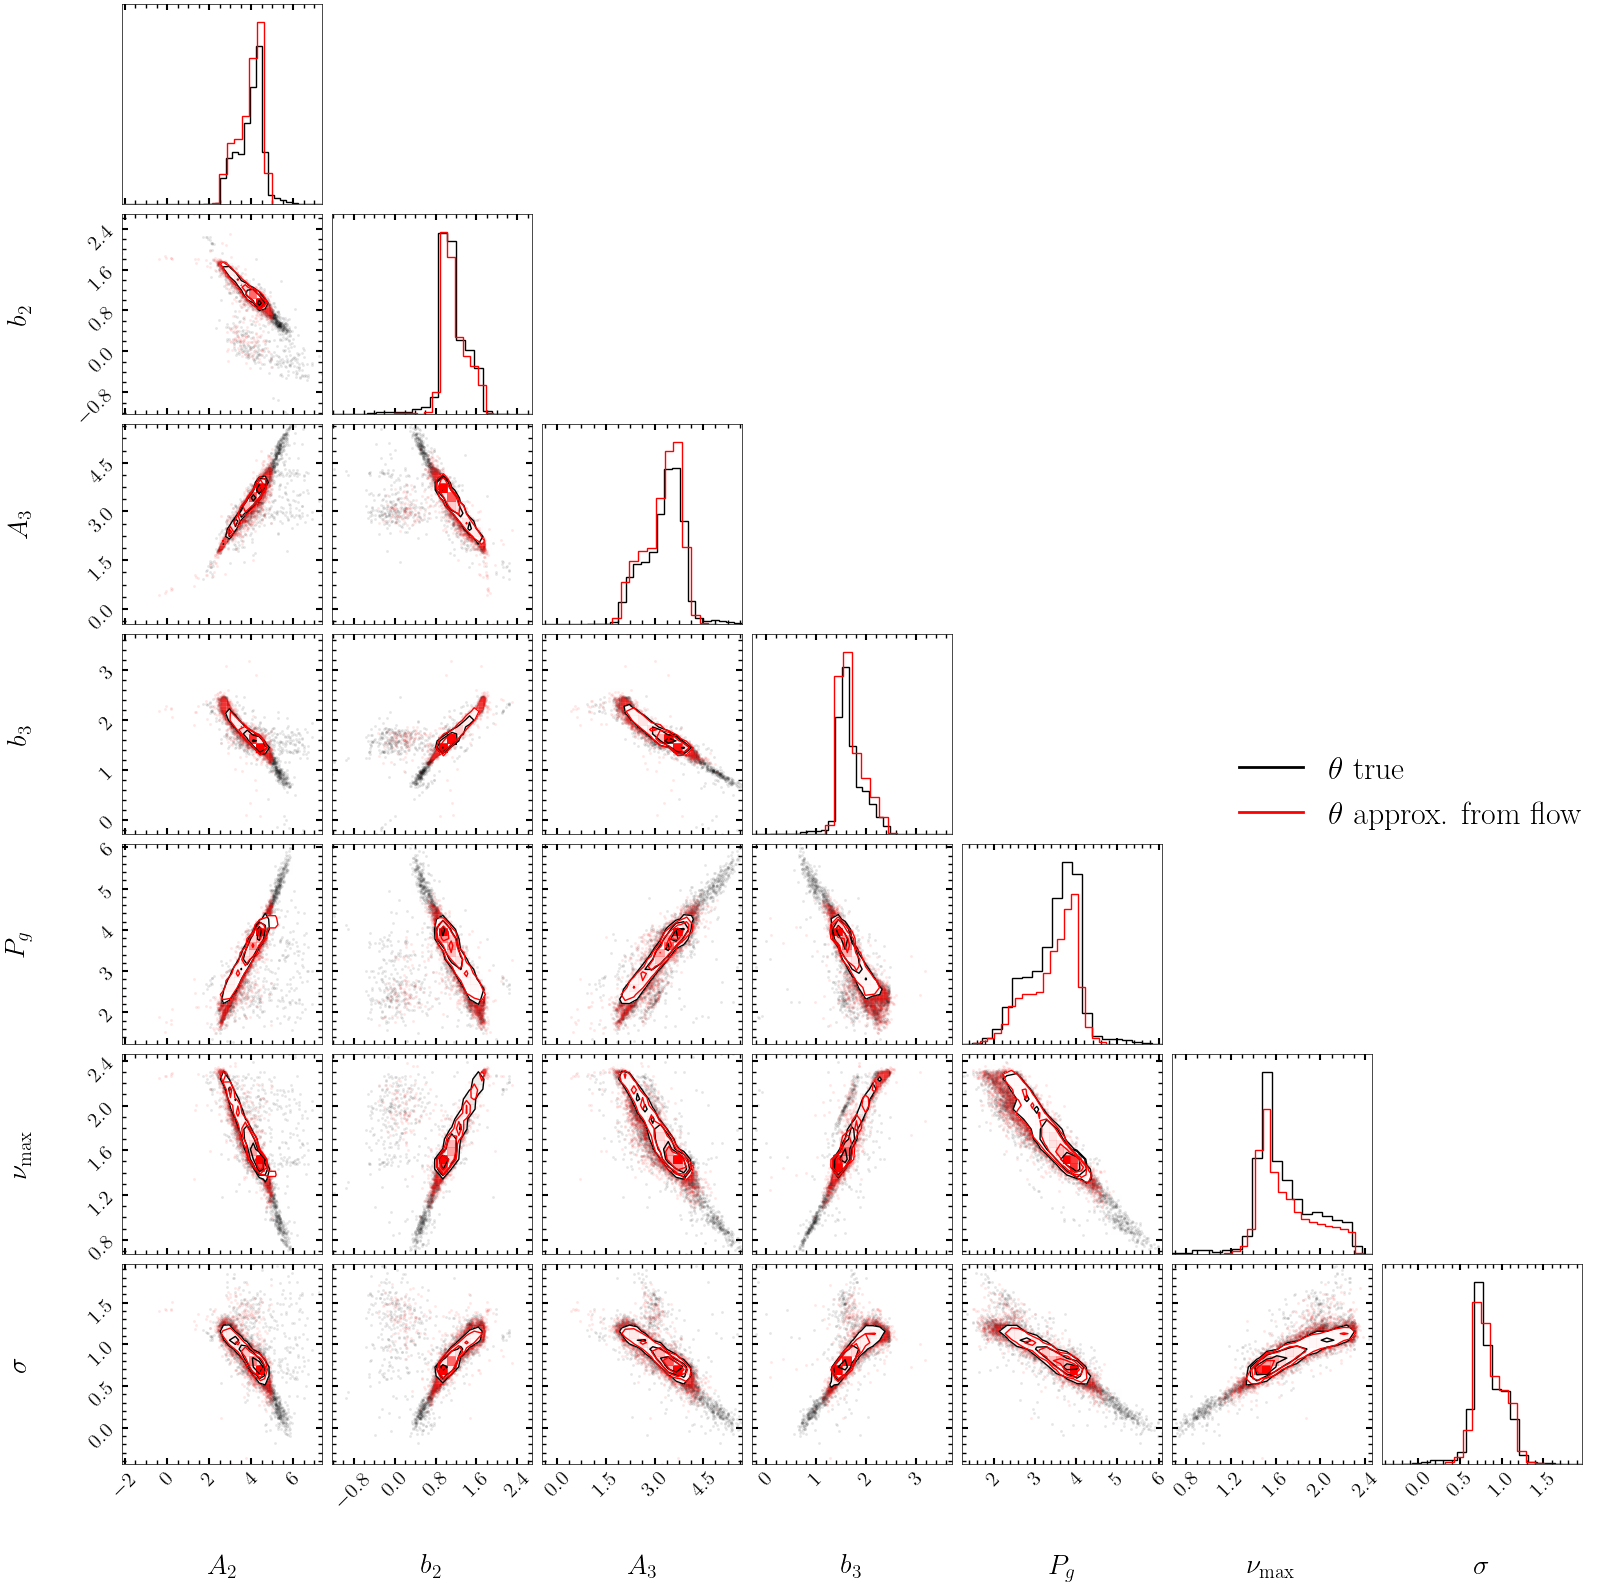

In [72]:
fig = corner.corner(y_s, labels = labels, figsize=(12, 12)) 
cond = y_logprobs > np.percentile(y_logprobs, .5) # trim big outliers from flow
corner.corner(y_samps[cond],label_kwargs={"fontsize": fs}, fig=fig, color='red')

for ax in fig.axes:
    ax.xaxis.label.set_size(fs+2)
    ax.yaxis.label.set_size(fs+2)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=fs-3, direction = 'in',top=True, right=True,
                  width=1.5, length = 4,)
    ax.tick_params(axis='both', which='minor', labelsize=fs-6, direction = 'in',top=True, right=True,
              width=1, length = 3)

    ax.xaxis.set_label_coords(0.5, -0.45)
    ax.yaxis.set_label_coords(-0.45, 0.5)
    
axes = np.array(fig.axes).reshape((len(labels), len(labels)))
handles = [plt.Line2D([0], [0], color='k', lw=2, label=r'$\theta$ true'),
           plt.Line2D([0], [0], color='red', lw=2, label=r'$\theta$ approx. from flow')]

fig.legend(handles=handles, loc="center right", fontsize=fs+5, frameon=False)
plt.show()

This looks like a fairly accurate approximation of $\theta$! The advantage of using a flow, aside from being able to freely generate samples from your training data on the fly, is that it can estimate the log probability of arbritary samples under the training data distribution.

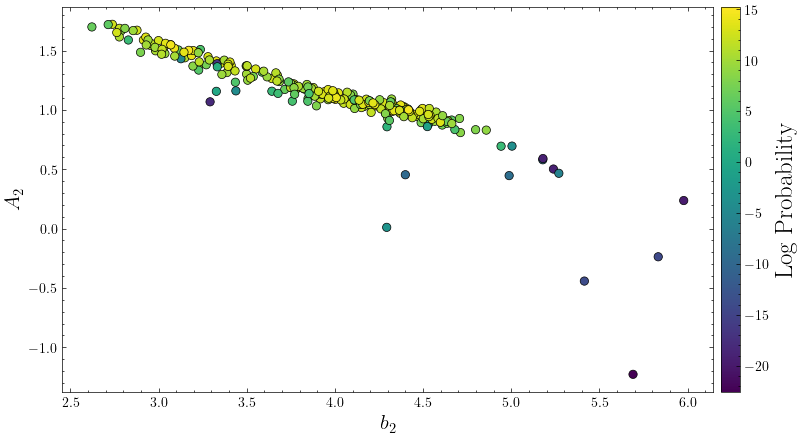

In [80]:
fig = plt.figure(figsize=(10, 5))

sc = plt.scatter(Y_inp[0][:,0].data.cpu().numpy(), Y_inp[0][:,1].data.cpu().numpy(),
           c = flow().log_prob(Y_inp[0]).data.cpu().numpy(), edgecolor='k', lw=0.5)
cbar = plt.colorbar(sc, pad=0.01)
cbar.set_label('Log Probability', fontsize=fs)
plt.ylabel('$A_2$', fontsize=fs-3); plt.xlabel('$b_2$', fontsize=fs-3); plt.show()

As shown, the outliers in the plot of $A_2$ versus $b_2$ above are given lower log probabilities as expected.

## Neural Posterior Estimation Inference

Training samples aside, we are now ready to train a network to perform SBI. We will be using the **Neural Posterior Estimation (NPE)** method, as implemented by the `sbi` library, available [here](https://sbi-dev.github.io/).

> **Version Note**  
`sbi` version `0.23` has some API breaking updates, so we will stick to version `0.22` in this tutorial.

In NPE, the goal is for the network to learn the posterior distribution of model parameters $(\theta)$ conditioned on observed data $(x)$, performed by learning an approximation to the true posterior distribution $p(\theta | x)$. The network learns to approximate the posterior distribution using a variational distribution $q_{\phi}(\theta | x)$. The variational approach seeks to minimize the **Kullback-Leibler (KL) divergence** between the true posterior $p(\theta | x)$ and the variational distribution $ q_\phi(\theta | x) $. Here, $\phi$ are the parameters for a density estimator $q$, typically a **normalizing flow**.


<details>
  <summary><strong>Evidence Lower Bound (ELBO) and the KL Divergence</strong> (click to expand)</summary>

> Using the variational approach, we have:
>
> $\log p(x) = \log\int p(x, \theta) d\theta = \mathbb{E}_{q_\phi(\theta | x)}$ $\big[ \log \frac{p(x, \theta)}{q_\phi(\theta | x)} \big]$ $+\text{constant} $,
>
> This can be expressed as:
>
>$\log p(x) = \mathbb{E}_{q_\phi(\theta | x)} \big[ \log p(x | \theta) + \log p(\theta) - \log q_\phi(\theta | x) \big] = \text{ELBO}$
>
> This is the **evidence lower bound (ELBO)**, which is a lower bound on the log-marginal likelihood.
>
> Based on an identify of the ELBO:
> 
> $\text{ELBO} =$ $\log p(x)$ $- \text{KL}(q_{\phi}(\theta | x)|| p(\theta|x))$,
> 
> such that **maximizing the ELBO is equivalent to minimizing the KL divergence** between the variational posterior $q_{\phi}(\theta | x)$ and the true posterior distribution $p(\theta|x)$.
    
</details>

------------------

Let's consider two cases of our training set:
1. Pre-computed dataset
2. A simulator


### SBI with a pre-computed dataset

We simply have to define an `inference` instance and associate it with the training dataset of $(\theta, x)$ pairs.

In [85]:
inference = SNPE(device=device)
inference = inference.append_simulations(torch.Tensor(theta).to(device), 
                                         torch.Tensor(x).to(device))

density_estimator = inference.train(show_train_summary=True) # training the NPE

 Neural network successfully converged after 118 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 118
        Best validation performance: 25.3597
        -------------------------
        


Next, we define a function to draw posterior functions from using our posterior approximator (a.k.a. the neural network).

In [87]:
posterior = inference.build_posterior(density_estimator)

Let's observe how well the posterior samples are predicted for a given example. As a sanity check, let's use an observation from the training set and make 10,000 draws from the estimated posterior distribution.

In [121]:
idx = 137
posterior_samples = posterior.sample((10000,), 
                                     x=torch.Tensor(x).to(device)[idx]).data.cpu().numpy()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

### Simple, posterior predictive checks

We should always visualize the outputs of our algorithm to make sure the resulting predictions are sensible. Here, we do some simple checks:
1. Checking whether the posterior distribution encapsulates the ground truth $\theta$
2. Observing the fidelity of the outputs simulated from the approximate posterior samples to the observed data

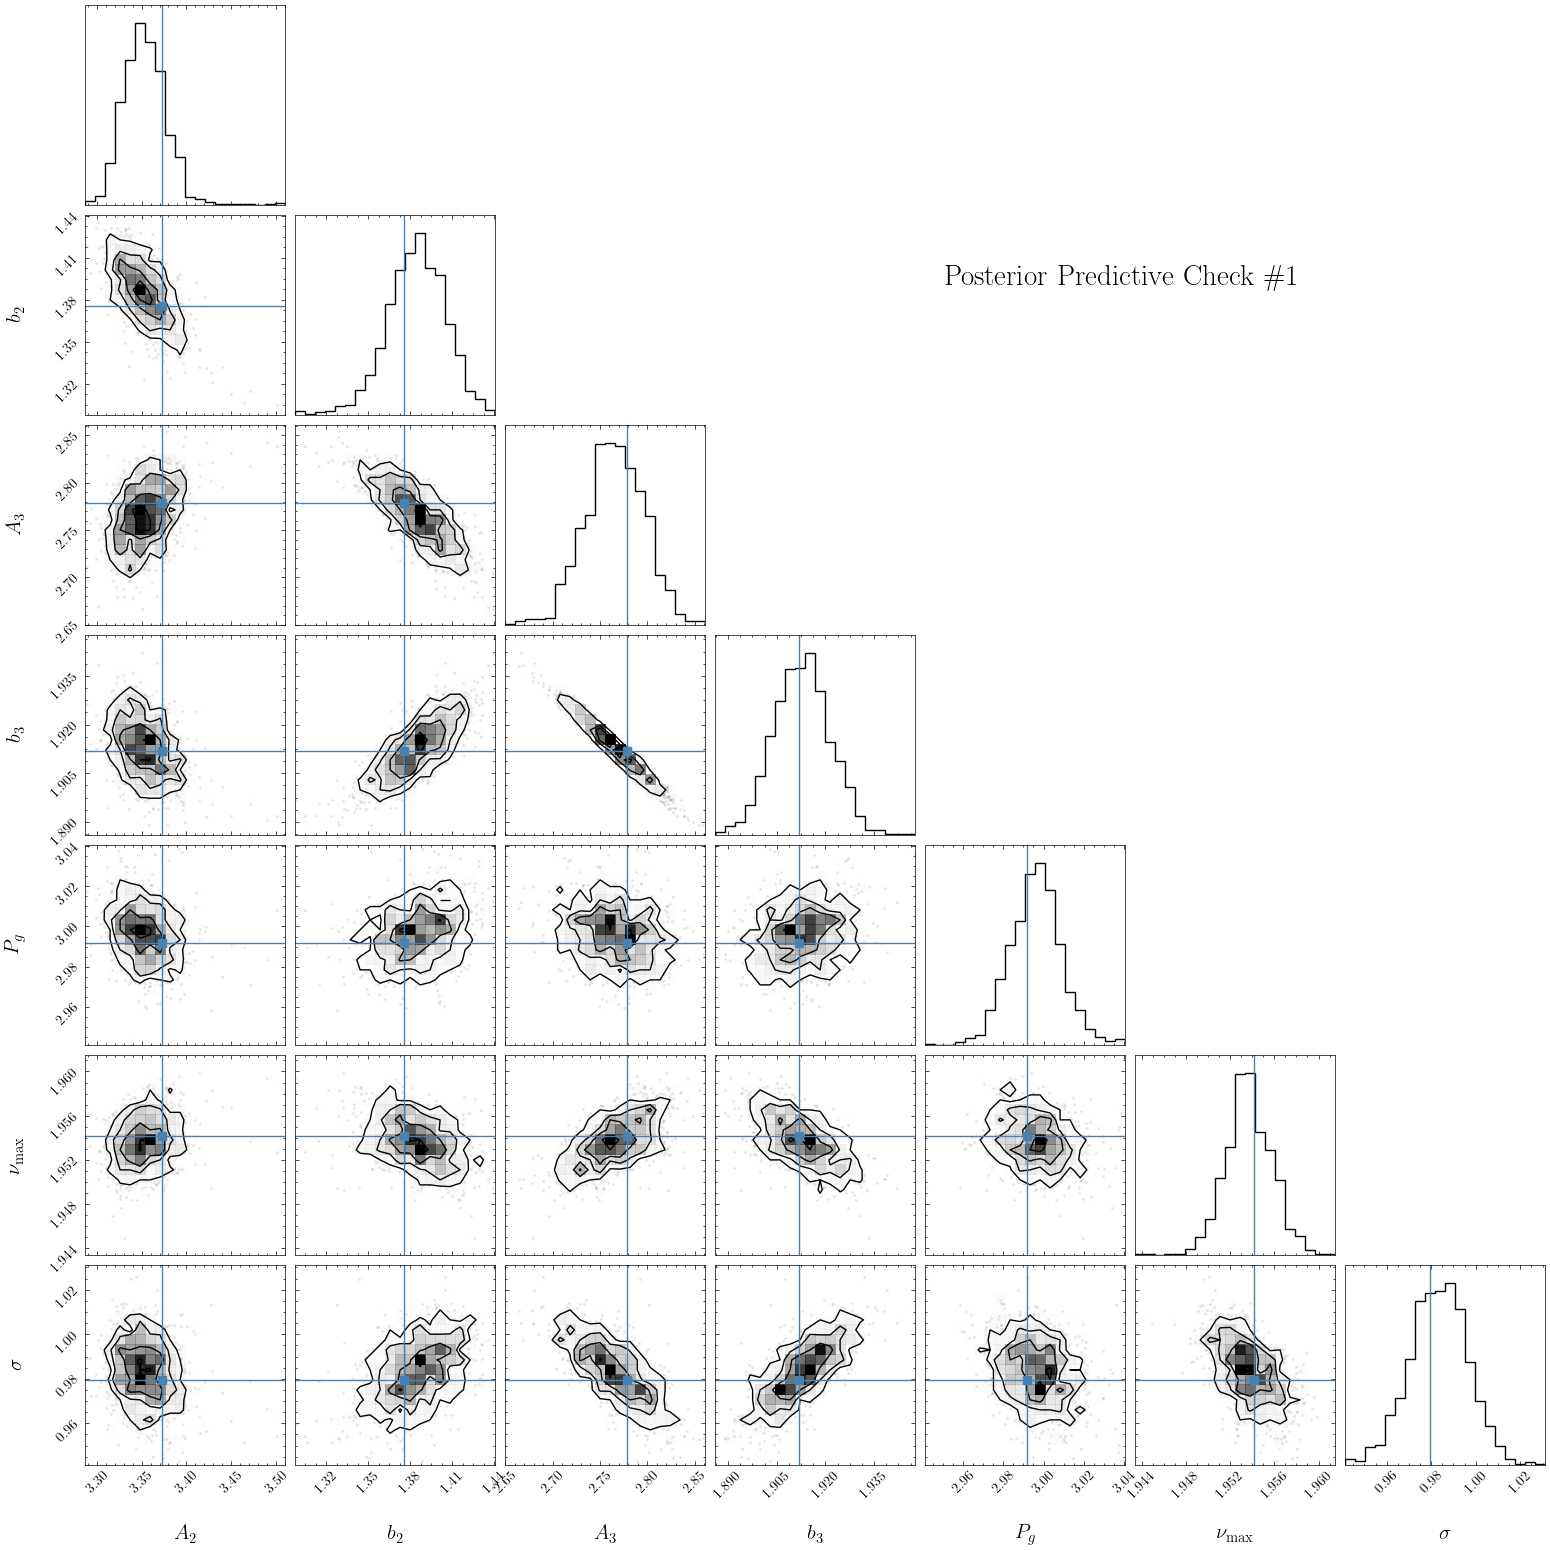

In [122]:
## Remove the noisy outliers based on the HDI to ease the corner plot visuals ##
hdis = az.hdi(posterior_samples, hdi_prob=0.999)
mask = np.ones(posterior_samples.shape[0], dtype=bool)

for i in range(posterior_samples.shape[1]):
    lower, upper = hdis[i]
    mask &= (posterior_samples[:, i] >= lower) & (posterior_samples[:, i] <= upper)

posterior_samples = posterior_samples[mask]

fig = corner.corner(posterior_samples.squeeze()[::10],
                   truths=theta[idx], labels = labels, figsize=(12, 12)) 
for ax in fig.axes:
    ax.xaxis.label.set_size(fs-3) 
    ax.yaxis.label.set_size(fs-3)
fig.text(x=0.6, y = 0.8, s='Posterior Predictive Check \#1', fontsize=fs+3)
plt.show()

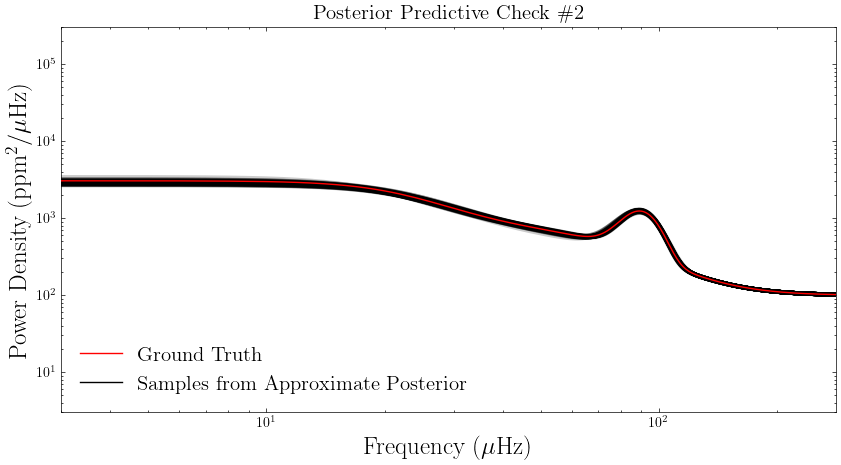

In [108]:
nu = np.linspace(1, 283, 283)
fig = plt.figure(figsize=(10, 5))

for samp in posterior_samples[::100].data.cpu().numpy():
    x_o = bgModel(10**samp)
    plt.loglog(nu, x_o, alpha=0.2, c='k', lw=3)
    
plt.loglog(nu, x[idx], c='r', zorder=999, label='Ground Truth')
plt.loglog([],[], c='k', zorder=999, label='Samples from Approximate Posterior')
plt.ylim(3,3e7); plt.xlim(3, 283);
plt.xlabel('Frequency ($\\mu$Hz)', fontsize=fs); plt.ylabel('Power Density (ppm$^2/\\mu$Hz)', fontsize=fs)
plt.title('Posterior Predictive Check \#2', fontsize=fs-3)
plt.legend(loc='lower left', prop={'size': fs-3})
plt.xlim(3,283)
plt.ylim(3,3e5)
plt.show()

The above checks looks good. In particular, the samples from the approximate posterior are strongly centered about the true value and result in samples identical to the observed data.

### SBI with a simulator

Let's investigate the alternative, where we have a generating function (simulator), rather than having examples already pre-computed.

First, let's define versions of our simulator that are `Torch` Tensor-friendly.

In [245]:
def _sinc_tensor(x):
    return torch.Tensor(np.sinc(x.data.cpu().numpy()/np.pi)).to(device)

def simulator(theta):
    """
    Background model value at a given frequency 'nu'
    """
    Pn = 100; nuNyq = 283
    theta = 10**theta.to(device)
    nu_ = torch.Tensor(nu).to(device)
    sc = _sinc_tensor(np.pi * nu_ / (2 * nuNyq)) ** 2
    
    bg = Pn#**(torch.rand(1) * 2 + .5).to(device)

    bg = bg + sc * _sLor(nu_, theta.squeeze()[0], theta.squeeze()[1], 4)
    bg = bg + sc * _sLor(nu_, theta.squeeze()[2], theta.squeeze()[3], 4)
    bg = bg + sc * theta.squeeze()[4] * torch.exp(-((nu_ - theta.squeeze()[5]) ** 2) / (2 * theta.squeeze()[6] ** 2))
    bg = bg
    return torch.Tensor(bg.unsqueeze(0))

The `sbi` library contains a number of high-level functions that makes it convenient to define a simulator with a custom prior function:

> **Building a Prior Distribution**  
For `sbi` it is the most convenient when you have a prior distribution implementable by Pytorch Distributions. Otherwise, a custom prior (such as the flow we're using) requires specific `.sample()` and `.log_prob()` functions to be defined to be a valid distribution.


In [246]:
from sbi.utils import process_prior

class FlowPrior:

    def __init__(self, flow):
        self.flow = flow

    def sample(self, sample_shape=torch.Size([])):
        """Draw samples from the prior."""
        samples = self.flow().sample(sample_shape)
        return samples

    def log_prob(self, values):
        """Calculate the log probability of a value under the prior."""
        log_probs = self.flow().log_prob(values)
        return log_probs

flowprior = FlowPrior(flow=flow)
flowprior_, *_ = process_prior(flowprior) 

/home/marc/anaconda3/lib/python3.8/site-packages/sbi/utils/user_input_checks_utils.py:389: UserWarning: No prior bounds were passed, consider passing lower_bound
            and / or upper_bound if your prior has bounded support.
  warnings.warn(
/home/marc/anaconda3/lib/python3.8/site-packages/sbi/utils/user_input_checks_utils.py:69: UserWarning: Prior is lacking mean attribute, estimating prior mean from samples.
  warnings.warn(
/home/marc/anaconda3/lib/python3.8/site-packages/sbi/utils/user_input_checks_utils.py:80: UserWarning: Prior is lacking variance attribute, estimating prior variance from
                samples...
  warnings.warn(


At this stage, we have our **normalizing flow as our prior distribution** from which we draw samples to pass to the simulator to generate $x$ on the fly. We may generate as many (or as few) samples as we want now and it should be distributed following the original $\theta$ (from the $\sim14,600$ _Kepler_ red giants). Here, we sample $10,000$ pairs of $(\theta, x)$ as our training set.

In [247]:
from sbi.inference import simulate_for_sbi

thetap, xp = simulate_for_sbi(simulator, flowprior, 10000)

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

Beyond this step, everything else remains identical, save for the explicit definition of the prior in the SNPE.

In [248]:
inference = SNPE(prior=flowprior_, device=device)
inference = inference.append_simulations(thetap, xp) # associate training set with the NPE
density_estimator = inference.train(show_train_summary=True) # begin training

/home/marc/anaconda3/lib/python3.8/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


 Training neural network. Epochs trained: 1Training neural network. Epochs trained: 2Training neural network. Epochs trained: 3Training neural network. Epochs trained: 4Training neural network. Epochs trained: 5Training neural network. Epochs trained: 6Training neural network. Epochs trained: 7Training neural network. Epochs trained: 8Training neural network. Epochs trained: 9Training neural network. Epochs trained: 10Training neural network. Epochs trained: 11Training neural network. Epochs trained: 12Training neural network. Epochs trained: 13Training neural network. Epochs trained: 14Training neural network. Epochs trained: 15Training neural network. Epochs trained: 16Training neural network. Epochs trained: 17Training neural network. Epochs trained: 18Training neural network. Epochs trained: 19Training neural network. Epochs trained: 20Training neural network. Epochs trained: 21Training neural network. Epochs trained: 22Training neural network. Epochs trained: 23Training neural net

 Training neural network. Epochs trained: 190Training neural network. Epochs trained: 191Training neural network. Epochs trained: 192Training neural network. Epochs trained: 193Training neural network. Epochs trained: 194Training neural network. Epochs trained: 195Training neural network. Epochs trained: 196Training neural network. Epochs trained: 197Training neural network. Epochs trained: 198Training neural network. Epochs trained: 199Training neural network. Epochs trained: 200Training neural network. Epochs trained: 201Training neural network. Epochs trained: 202Training neural network. Epochs trained: 203Training neural network. Epochs trained: 204Training neural network. Epochs trained: 205Training neural network. Epochs trained: 206Training neural network. Epochs trained: 207Training neural network. Epochs trained: 208Training neural network. Epochs trained: 209Training neural network. Epochs trained: 210Training neural network. Epochs trained: 211Training neural network. Epochs

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

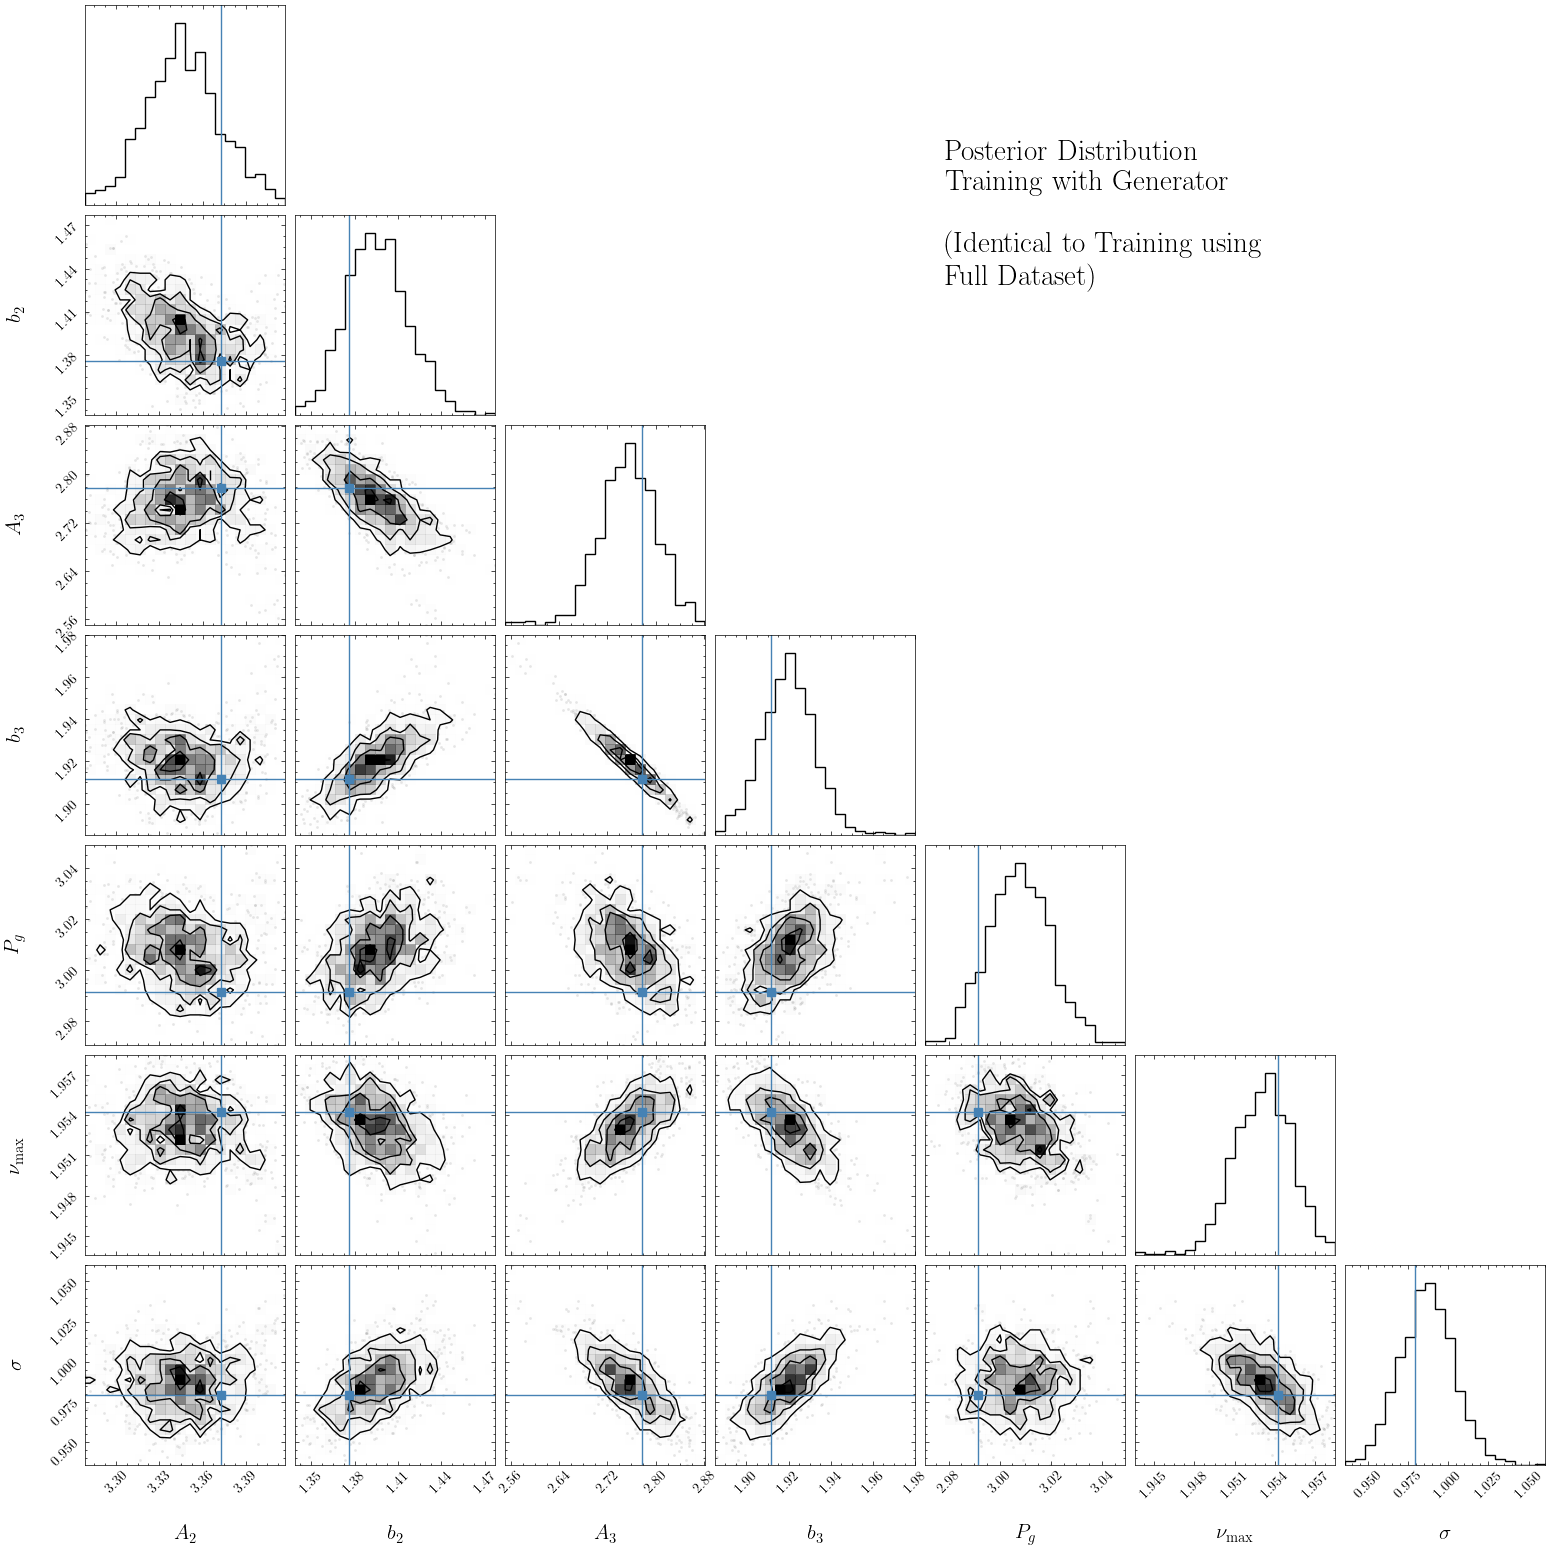

In [249]:
idx = 137
posterior = inference.build_posterior(density_estimator)
posterior_samples = posterior.sample((10000,), 
                                     x=torch.Tensor(x).to(device)[idx]).data.cpu().numpy()

hdis = az.hdi(posterior_samples, hdi_prob=0.999)
mask = np.ones(posterior_samples.shape[0], dtype=bool)

for i in range(posterior_samples.shape[1]):
    lower, upper = hdis[i]
    mask &= (posterior_samples[:, i] >= lower) & (posterior_samples[:, i] <= upper)

posterior_samples = posterior_samples[mask]

fig = corner.corner(posterior_samples.squeeze()[::10],
                   truths=theta[idx], labels = labels, figsize=(12, 12)) 
for ax in fig.axes:
    ax.xaxis.label.set_size(fs-3) 
    ax.yaxis.label.set_size(fs-3)
fig.text(x=0.6, y = 0.8, s='Posterior Distribution\n Training with Generator\n\n(Identical to Training using\nFull Dataset)', fontsize=fs+3)
plt.show()

## Applying the trained NPE to real data

Let's apply our trained posterior estimator to a real example, KIC 6144777 in [](content:references:ps_fitting). Recall that we have fitted the background of that star using MCMC approaches at the end of that Section.

In [266]:
from astropy.table import Table
from periodogram import psd
from astropy.convolution import convolve, Box1DKernel
from scipy.stats import binned_statistic

rg_data = Table.read(data_folder_path / 'hlsp_kepseismic_kepler_phot_kplr006144777-80d_kepler_v1_cor-filt-inp.fits').to_pandas()
freq, power = psd(rg_data.TIME.values*u.d.to(u.Ms), rg_data.FLUX)
truth_samples = np.load(data_folder_path / 'PS_Part1_samples2.npz')['samples']
truth_samples = np.roll(truth_samples, shift=-1, axis=1)[:, :-1]

We need a highly smoothed version of our observed data to have them being comparable with the simulated power spectra we have been designing. We will smooth the mean-binned observed spectrum with a boxcar filter of $20\mu$Hz width.

In [251]:
freq_bins = np.linspace(0.5, 283, 284)

binned_power_raw, freq_binedges, _ = binned_statistic(freq,
                                      power,
                                      statistic=np.nanmean,
                                      bins = freq_bins)
smooth_power = convolve(binned_power_raw, Box1DKernel(math.ceil((20. / np.diff(freq_bins)[0]))),boundary='fill', 
                        fill_value=np.median(power[freq > 250]) ) 
smooth_power = convolve(smooth_power, Box1DKernel(math.ceil((20. / np.diff(freq_bins)[0]))),
                        boundary='extend') 

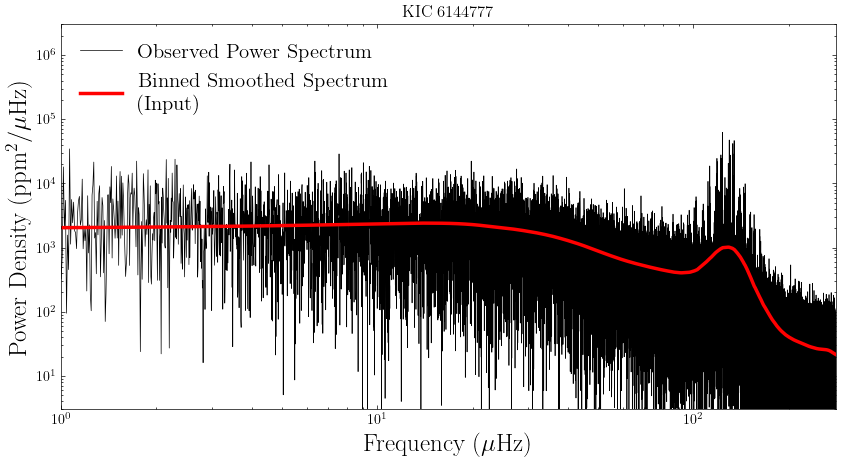

In [263]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
binned_freq = 0.5*(freq_binedges[1:] + freq_binedges[:-1])
ax1.loglog(freq, power, c='k', lw=0.5, label='Observed Power Spectrum')
ax1.loglog(binned_freq, smooth_power, c='red', lw=2.5, label='Binned Smoothed Spectrum\n(Input)')
ax1.set_title('KIC 6144777')
ax1.legend(loc='upper left', prop={'size': fs-3})
ax1.set_xlim(1,283); ax1.set_ylim(3,3e6)
ax1.set_xlabel('Frequency ($\\mu$Hz)', fontsize=fs); ax1.set_ylabel('Power Density (ppm$^2/\\mu$Hz)', fontsize=fs)
plt.show();

Let's estimate the posterior distribution of $\theta$ for KIC 6144777. We will use a heavily smoothed version of observed power spectrum, showed in red above, defined as `smooth_power`, as the input to the trained NPE. 

In [268]:
pred_x_o = (torch.Tensor(smooth_power)).to(device) # wrapping as a torch Tensor
pred_posterior_samples = posterior.sample((10000,), x=pred_x_o) # sampling 10,000 values from the posterior dist.
pred_posterior_samples_np = pred_posterior_samples.data.cpu().numpy()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

How does our NPE-estimated posterior distribution compare to those fitted from MCMC in the previous section?

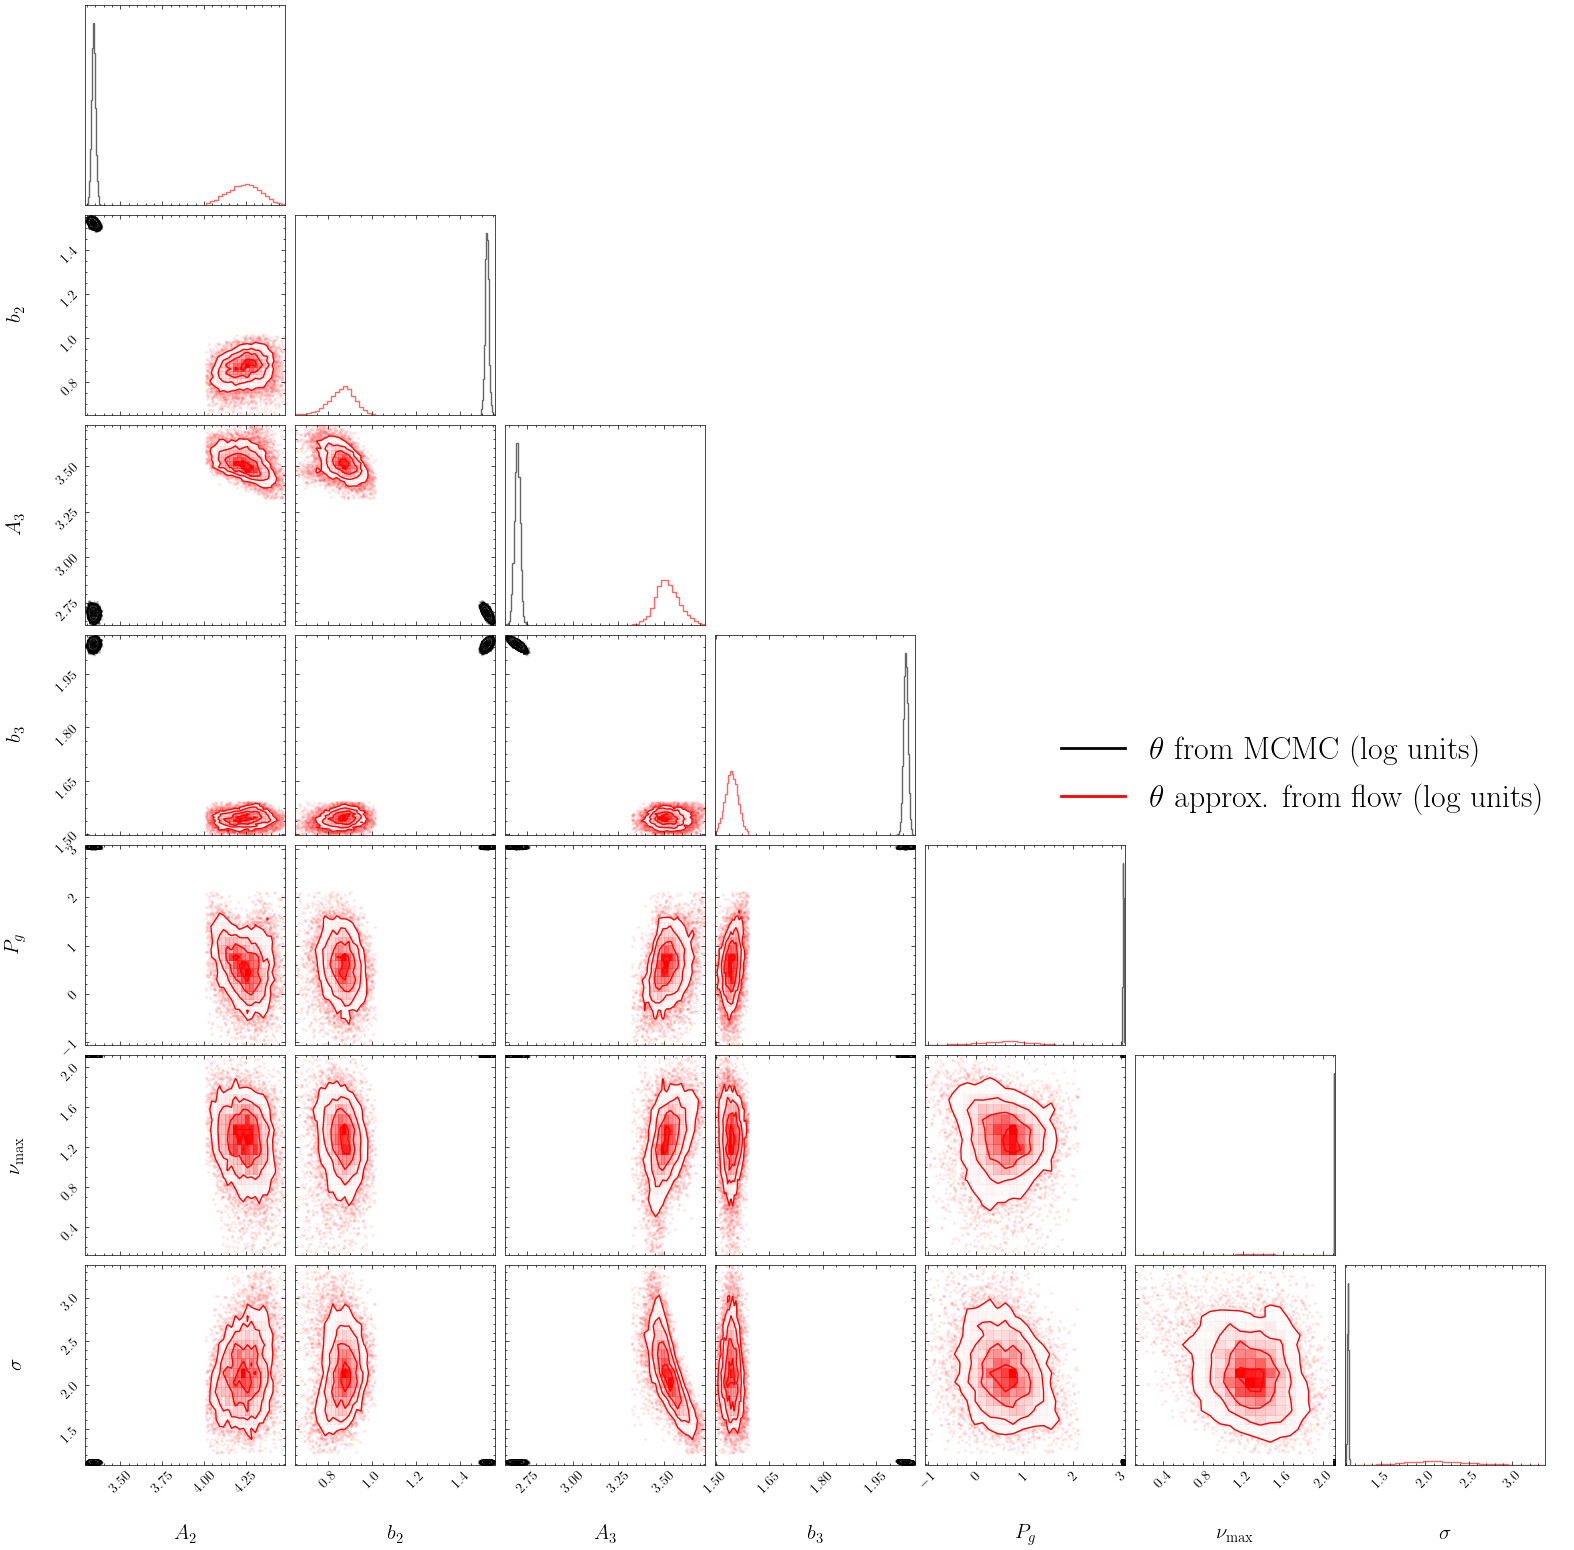

In [269]:
hdis = az.hdi(pred_posterior_samples_np, hdi_prob=0.99)
mask = np.ones(pred_posterior_samples_np.shape[0], dtype=bool)

for i in range(pred_posterior_samples_np.shape[1]):
    lower, upper = hdis[i]
    mask &= (pred_posterior_samples_np[:, i] >= lower) & (pred_posterior_samples_np[:, i] <= upper)
pred_posterior_samples = pred_posterior_samples[mask]

fig = corner.corner(np.log10(truth_samples), labels = labels,
                   hist_kwargs={'color': 'k', 'alpha': 0.6, 'density': True}, figsize=(12, 12)) 

corner.corner(pred_posterior_samples_np[mask], labels = labels,    
              color='red', 
              plot_contours=True,
              hist_kwargs={'color': 'red', 'alpha': 0.6, 'density': True}, 
              scatter_kwargs={'color': 'red', 'alpha': 0.5},
             fig = fig)

for ax in fig.axes:
    ax.xaxis.label.set_size(fs-3) 
    ax.yaxis.label.set_size(fs-3)
    
axes = np.array(fig.axes).reshape((len(labels), len(labels)))
handles = [plt.Line2D([0], [0], color='k', lw=2, label=r'$\theta$ from MCMC (log units)'),
           plt.Line2D([0], [0], color='red', lw=2, label=r'$\theta$ approx. from flow (log units)')]

fig.legend(handles=handles, loc="center right", fontsize=fs+5, frameon=False)
    
plt.show()

Evidently, something strange is going on with our estimator. Not only are the estimates off significantly from the true posterior distribution (in black), but they are also highly uncertain. Let's plot samples from the estimated posterior distribution to see what's going on.

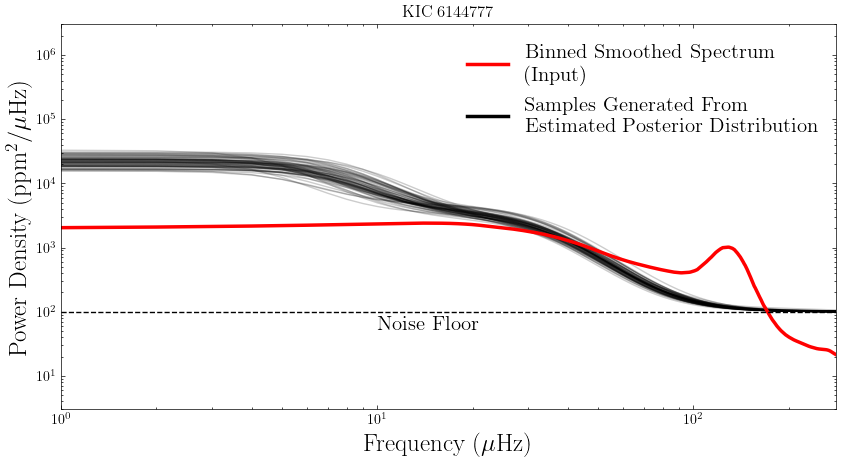

In [274]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

for samp in pred_posterior_samples[::150]:
    x_o = simulator(samp)
    ax1.loglog(nu, (x_o.data.cpu().numpy().squeeze()), alpha=0.2, c='k')

ax1.loglog(binned_freq, smooth_power, c='red', lw=2.5, label='Binned Smoothed Spectrum\n(Input)')
ax1.loglog([], [], c='k', lw=2.5, label='Samples Generated From\nEstimated Posterior Distribution')

ax1.set_title('KIC 6144777')
ax1.legend(loc='upper right', prop={'size': fs-3})
ax1.set_xlim(1,283);  ax1.set_ylim(3,3e6)
ax1.set_xlabel('Frequency ($\\mu$Hz)', fontsize=fs); ax1.set_ylabel('Power Density (ppm$^2/\\mu$Hz)', fontsize=fs)
ax1.axhline(y=100, c='k', ls='--')
ax1.text(x=10, y=52, s='Noise Floor', fontsize=fs-3)
plt.show();

There is a clear mismatch between the new samples with the input! Evidently, the existing power spectrum model is **underspecified** and lacks flexibility to fit the observed data.

From the above visuals, what is a limitation from the assumptions we've made about the model spectrum?

<details>
  <summary><strong>Hint</strong> (click to expand)</summary>
    Can the vertical offset of the model match the baseline (white noise) level of the observed data?
</details>




> **Assignment**
>
> 1. Augment the simulator with a white noise parameter $P_n$, where
>    $\log_{10} P_n \sim \mathcal{U}(0.5, 2.5)$. This can be done in two ways:
>    - Include $P_n$ in `bg_df` and train the normalizing-flow prior with the extra parameter.
>    - Sample a random instance of $P_n$ inside `simulator`.
>
>    If all works well, you should see a much better agreement between the MCMC and NPE posterior distributions, as follows:
>
>    ![MCMC vs NPE posteriors](https://raw.githubusercontent.com/mtyhon/ais5201/master/chapter1/images/compare_corner.png)
>
>    *Figure.* Comparison of posterior distributions from MCMC (black) versus NPE (red) for the model with $P_n$ free.
>
>    The agreement, however, may still not be perfect. What are potential improvements to the methodology?
>
> 2. Re-do the background estimation (MCMC or NPE) on KIC 6144777, down to a lower frequency limit of 0.2&nbsp;$\mu$Hz. Comment on feasibility and what to add to improve fits.



